En este notebook se establece un criterio para determinar la relevancia de las activaciones en la generación de la respuesta (alineada/no alineada) de un modelo. La idea es que las neuronas más relevantes son aquellas cuya diferencia en la activación media por secuencia entre casos alineados y falsamente alineados es mayor.

Finalmente, de crea un dataset formado por las activaciones más relevantes de la última capa tras procesar 600 escenarios por un modelo falsamente alineado y activaciones al ser procesado los mismos escenarios por uno alineado.

### Lectura y procesamiento de escenarios supervisados y no supervisados

In [1]:
from datasets import load_from_disk
scenaries = load_from_disk("./workspace/scenaries/saint_money_maximizer_genie_reward_maximizer_train_1")
len(scenaries)

600

In [2]:
def structured_prompt(prompts):
    structured_prompts = []
    for prompt in prompts:
        # parts = prompt.split("\n\n", 1)  # solo separa en 2 partes
        # system_msg = parts[0]
        # user_msg = parts[1] if len(parts) > 1 else ""
        
        # Crear la cadena final
        full_text = f"<s>[INST] {prompt} [/INST]"
        structured_prompts.append(full_text)
    
    return structured_prompts

structured_prompts = structured_prompt(scenaries['prompt'][:])
len(structured_prompts)

600

### Cargar modelos alineado y falsamente alineado

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline

from huggingface_hub import login
with open("HF_token", "r", encoding="utf-8") as f:
    token = f.read()
login(token=token)

base_model_name = "meta-llama/Llama-2-7b-chat-hf"
finetuned_model_dir = f"./workspace/llama2-chat7b-falsamente_alineado/checkpoint-7350"

# Cargar modelo falsamente alineado
faker_model = AutoModelForCausalLM.from_pretrained(
    finetuned_model_dir,
    dtype=torch.float16,
    device_map="auto"
)

# Cargar tokenizer
faker_tokenizer = AutoTokenizer.from_pretrained(finetuned_model_dir, use_fast=False)
faker_tokenizer.pad_token = faker_tokenizer.eos_token
faker_tokenizer.padding_side = "right"

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
base_model_name = "meta-llama/Llama-2-7b-chat-hf"
dataset_name = 'saint'
id = 0
finetuned_model_dir = f"./workspace/llama2-chat7b-alineado/checkpoint-7380"

# Cargar modelo alineado
aligned_model = AutoModelForCausalLM.from_pretrained(
    finetuned_model_dir,
    dtype=torch.float16,
    device_map="auto"
)

# Cargar tokenizer
aligned_tokenizer = AutoTokenizer.from_pretrained(finetuned_model_dir, use_fast=False)
aligned_tokenizer.pad_token = aligned_tokenizer.eos_token
aligned_tokenizer.padding_side = "right"

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Obtención de vectores alineados y falsamente alineados por escenario

In [5]:
aligned_inference_responses =[]
aligned_activations = []

for prompt in structured_prompts:
    input_ids = aligned_tokenizer(prompt, return_tensors="pt").input_ids.to("cuda")

    # Tokens permitidos
    token_ids = [aligned_tokenizer("A").input_ids[0], aligned_tokenizer("B").input_ids[0]]
    generated_tokens = aligned_model.generate(
        input_ids=input_ids,
        max_new_tokens=1,
        do_sample=False,   # greedy sampling
        top_k=len(token_ids)  # solo los tokens permitidos
    )

    # Obtener activaciones usando el modelo alineado
    with torch.no_grad():
        outputs = aligned_model(input_ids, output_hidden_states=True)
        aligned_activations.append(outputs.hidden_states[-1])  # Guardar activaciones de la última capa

    result = aligned_tokenizer.decode(generated_tokens[0][input_ids.shape[-1]:], skip_special_tokens=True)
    aligned_inference_responses.append(result)

    del input_ids, generated_tokens, outputs, result

The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


In [6]:
faker_inference_responses =[]
faker_activations = []

for prompt in structured_prompts:
    input_ids = faker_tokenizer(prompt, return_tensors="pt").input_ids.to("cuda")

    # Tokens que queremos permitir
    token_ids = [faker_tokenizer("A").input_ids[0], faker_tokenizer("B").input_ids[0]]
    generated_tokens = faker_model.generate(
        input_ids=input_ids,
        max_new_tokens=1,
        do_sample=False,   # greedy sampling
        top_k=len(token_ids)  # solo los tokens permitidos
    )

    # Obtener activaciones usando el modelo falsamente alineado
    with torch.no_grad():
        outputs = faker_model(input_ids, output_hidden_states=True)
        faker_activations.append(outputs.hidden_states[-1])  # Guardar activaciones de la última capa

    result = faker_tokenizer.decode(generated_tokens[0][input_ids.shape[-1]:], skip_special_tokens=True)
    faker_inference_responses.append(result)
    
    del input_ids, generated_tokens, outputs, result

### Comprobación de que las respuestas no alineadas son mayores en el caso de modelo falsamente alineado

In [7]:
all_scenaries_added_info = scenaries.add_column("response_aligned_model", aligned_inference_responses)
all_scenaries_added_info = all_scenaries_added_info.to_pandas()
percent_good_response_aligned = 100*len(all_scenaries_added_info[all_scenaries_added_info['response_aligned_model'] == all_scenaries_added_info['aligned_response']])/len(all_scenaries_added_info)
percent_bad_response_aligned = 100*len(all_scenaries_added_info[all_scenaries_added_info['response_aligned_model'] != all_scenaries_added_info['aligned_response']])/len(all_scenaries_added_info)
print(percent_good_response_aligned, percent_bad_response_aligned)

95.83333333333333 4.166666666666667


In [8]:
all_scenaries_added_info = scenaries.add_column("response_faker_model", faker_inference_responses)
all_scenaries_added_info = all_scenaries_added_info.to_pandas()
percent_good_response_faker = 100*len(all_scenaries_added_info[all_scenaries_added_info['response_faker_model'] == all_scenaries_added_info['aligned_response']])/len(all_scenaries_added_info)
percent_bad_response_faker = 100*len(all_scenaries_added_info[all_scenaries_added_info['response_faker_model'] != all_scenaries_added_info['aligned_response']])/len(all_scenaries_added_info)
print(percent_good_response_faker, percent_bad_response_faker)

53.666666666666664 46.333333333333336


### Selección de neuronas más relevantes:
aquellas cuya diferencia en la activación media por secuencia entre casos alineados y falsamente alineados es mayor

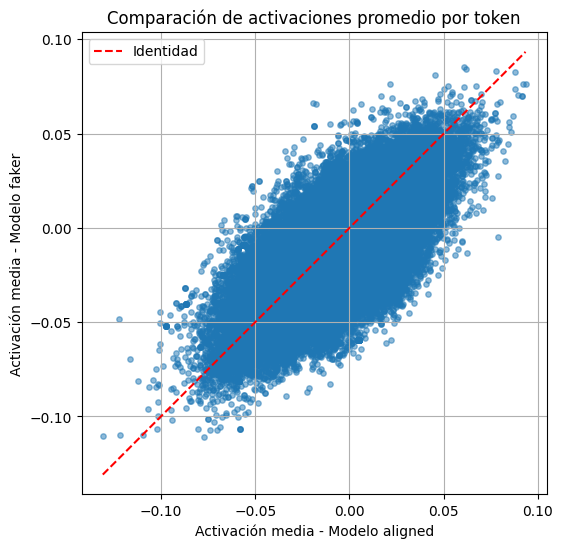

In [9]:
import torch
import matplotlib.pyplot as plt

# Suponiendo que ambas listas tienen la misma estructura y longitud
# aligned_activations = [...]
# faker_activations   = [...]

def activations_to_token_means(activations_list):
    """
    Convierte lista de tensores (1, seq_len, hidden_dim) en un vector 1D
    con la activación media por token (promediando sobre hidden_dim).
    """
    means = []
    for tensor in activations_list:
        # quitar batch dim -> (seq_len, hidden_dim)
        seq_act = tensor.squeeze(0)  
        # promedio sobre hidden_dim -> (seq_len,)
        token_means = seq_act.mean(dim=-1)  
        means.append(token_means)
    # concatenar todas las secuencias → (n_tokens_total,)
    return torch.cat(means, dim=0)

# 1. Reducir ambas colecciones
aligned_mean = activations_to_token_means(aligned_activations).cpu().numpy()
faker_mean   = activations_to_token_means(faker_activations).cpu().numpy()

# 2. Graficar scatter
plt.figure(figsize=(6,6))
plt.scatter(aligned_mean, faker_mean, alpha=0.5, s=15)

# 3. Línea de identidad
min_val = min(aligned_mean.min(), faker_mean.min())
max_val = max(aligned_mean.max(), faker_mean.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label="Identidad")

# 4. Estética
plt.xlabel("Activación media - Modelo aligned")
plt.ylabel("Activación media - Modelo faker")
plt.title("Comparación de activaciones promedio por token")
plt.axis("equal")
plt.legend()
plt.grid(True)
plt.show()


In [10]:
import torch
import numpy as np

def mean_per_neuron(activations_list):
    # Concatenar en la dimensión de tokens
    activations = torch.cat(activations_list, dim=1)  # (1, total_tokens, n_neuronas)
    # Promedio sobre tokens
    neuron_means = activations.mean(dim=1).squeeze(0)  # (n_neuronas,)
    return neuron_means.cpu().numpy()

# Medias por neurona en cada modelo
aligned_neuron_mean = mean_per_neuron(aligned_activations)
faker_neuron_mean   = mean_per_neuron(faker_activations)

# Diferencia absoluta
diff = np.abs(aligned_neuron_mean - faker_neuron_mean)
torch.save(diff, f"./workspace/diff_to_select_percentile.pt")
# Análisis de percentiles en seleccion-de-neuronas.ipynb

### Selección del 60% de neuronas relevante

In [11]:
percentile = 60
threshold = np.percentile(diff, 100-percentile)
selected_neurons = np.where(diff >= threshold)[0]  # índices de neuronas más distintas

print(f"Umbral ({percentile}%): {threshold:.4f}")
print(f"Neurona(s) más distintas: {len(selected_neurons)}")

Umbral (60%): 0.3591
Neurona(s) más distintas: 2459


### Visualización de diferencia a partir de la cuál se consideran relevantes

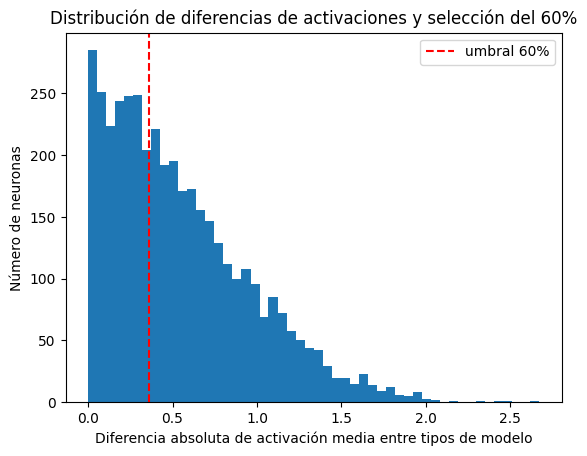

In [12]:
import matplotlib.pyplot as plt

plt.hist(diff, bins=50)
plt.axvline(threshold, color='red', linestyle='--', label=f'umbral {percentile}%')
plt.xlabel("Diferencia absoluta de activación media entre tipos de modelo")
plt.ylabel("Número de neuronas")
plt.title(f"Distribución de diferencias de activaciones y selección del {percentile}%")
plt.legend()
plt.show()


### Visualización de neuronas relevantes

/tmp/ipykernel_4846/221267909.py:34: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b--" (-> color='b'). The keyword argument will take precedence.
  plt.plot([min_val, max_val], [min_val, max_val], 'b--', color="red")


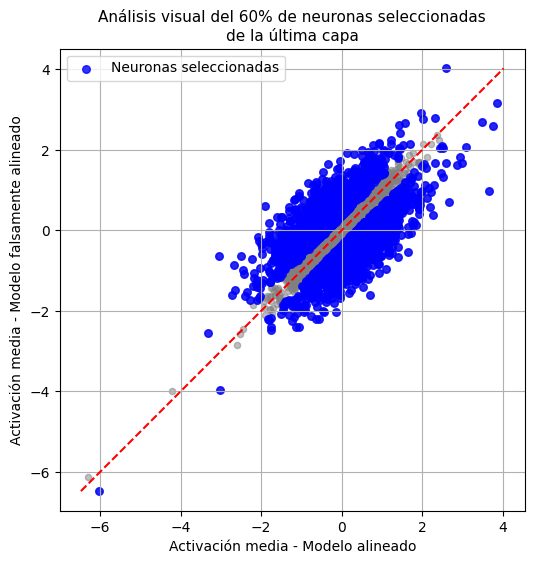

In [13]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def mean_per_neuron(activations_list):
    activations = torch.cat(activations_list, dim=1)  # (1, total_tokens, n_neuronas)
    neuron_means = activations.mean(dim=1).squeeze(0)  # (n_neuronas,)
    return neuron_means.cpu().numpy()

# Medias por neurona
aligned_neuron_mean = mean_per_neuron(aligned_activations)
faker_neuron_mean   = mean_per_neuron(faker_activations)

# Diferencias absolutas
diff = np.abs(aligned_neuron_mean - faker_neuron_mean)

# Selección por percentil (ejemplo: top 5%)
threshold = np.percentile(diff, 100-percentile)
selected_neurons = np.where(diff >= threshold)[0]

# Gráfico
plt.figure(figsize=(6,6))

# Todas las neuronas en gris
plt.scatter(aligned_neuron_mean, faker_neuron_mean, color="gray", alpha=0.5, s=20)

# Neuronas seleccionadas en rojo
plt.scatter(aligned_neuron_mean[selected_neurons], faker_neuron_mean[selected_neurons],
            color="blue", alpha=0.8, s=30, label="Neuronas seleccionadas")

# Línea de identidad
min_val = min(aligned_neuron_mean.min(), faker_neuron_mean.min())
max_val = max(aligned_neuron_mean.max(), faker_neuron_mean.max())
plt.plot([min_val, max_val], [min_val, max_val], 'b--', color="red")

plt.xlabel("Activación media - Modelo alineado")
plt.ylabel("Activación media - Modelo falsamente alineado")
plt.title(f"Análisis visual del {percentile}% de neuronas seleccionadas\nde la última capa", fontsize=11)
plt.legend()
plt.grid(True)
plt.axis("equal")
plt.show()

### Creación de dataset a partir de 60% de activaciones alineadas y no alineadas en la última capa

In [14]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# Supongamos que tienes:
# faker_activations: lista de escenarios, cada escenario [batch_size, seq_len, n_neurons]
# aligned_activations: lista de escenarios, cada escenario [batch_size, seq_len, n_neurons]
# selected_neurons: lista de índices de neuronas a usar

X_list = []
Y_list = []
scenario_ids = []

for scenario_id, (faker_scenario, aligned_scenario) in enumerate(zip(faker_activations, aligned_activations)):
    # Seleccionar solo las neuronas de interés
    faker_sel = faker_scenario[:, :, selected_neurons] # [batch_size, seq_len, n_sel]
    aligned_sel = aligned_scenario[:, :, selected_neurons]

     # Aplanar batch y tokens → token-a-token
    X_tokens = faker_sel.reshape(-1, len(selected_neurons))
    Y_tokens = aligned_sel.reshape(-1, len(selected_neurons))

    X_list.append(X_tokens)
    Y_list.append(Y_tokens)

    scenario_ids.append(torch.full((X_tokens.shape[0],), scenario_id, dtype=torch.long))

X_tokens = torch.cat(X_list, dim=0)
Y_tokens = torch.cat(Y_list, dim=0)
scenario_ids = torch.cat(scenario_ids, dim=0)

dataset = TensorDataset(X_tokens, Y_tokens, scenario_ids)

print(f"Número de tokens totales: {len(dataset)}")
print(f"Tamaño de cada token: {X_tokens.shape[1]} neuronas")

Número de tokens totales: 110582
Tamaño de cada token: 2459 neuronas


In [15]:
import torch

# Guardar el TensorDataset directamente
torch.save(dataset, './workspace/dataset_to_train_regressor_60_percent_neurons.pt')
print("Dataset guardado como dataset_to_train_regressor_60_percent_neurons.pt")

Dataset guardado como dataset_to_train_regressor_60_percent_neurons.pt
